In [1]:
import numpy as np
import h5py
import json
import sys
sys.path.append('F:\Linux')
import illustris_python as il
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap


def xyline(x, y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def LoadMergHist(simu, subhaloID):
    '''
    return subhalo's main progenitor and merger history with snapshot
    '''
    if (simu == 'TNG') or (simu == 'tng'):
        ldir = 'f:/Linux/localRUN/tng_DiskMerTree/%d.json' % subhaloID
    else:
        ldir = 'f:/Linux/localRUN/il1_DiskMerTree/%d.json' % subhaloID
    
    with open(ldir) as f:
        data = json.load(f)
    
    Main = np.array(data['Main'])
    return dict(zip(Main[:, 0], Main[:, 1])), np.array(data['Mergers'])

def HistValAndBin(nums, bins, more=0, mask=0):
    if mask == 1:
        reMask = []

    val = []
    tmp = nums[nums < bins[1]]
    if mask == 1:
        reMask.append(nums < bins[1])
    val.append(len(tmp))

    for i in range(1,len(bins)-1):
        tmp = nums[(nums > bins[i]) & (nums <= bins[i+1])]
        val.append(len(tmp))
        if mask == 1:
            reMask.append((nums > bins[i]) & (nums <= bins[i+1]))

    if more == 1:
        tmp = nums[nums > bins[-1]]
        val.append(len(tmp))
        if mask == 1:
            reMask.append(nums > bins[-1])

    if mask == 0:
        return np.array(val)
    else:
        return np.array(val), np.array(reMask)

def ErrorBarMedian(data):
    #return 25%, 50%, 75%
    if len(data) == 0:
        return 0, 0, 0
    elif len(data) < 3:
        return 0, np.median(data), 0
    else:
        data.sort()
        return data[int(len(data) / 4)], np.median(data), data[int(len(data) * 0.75)]

def Ydata(simu, ids, rawdata, SnapList, Redshift):
    dataWithZ = {}
    for x in Redshift:
        dataWithZ[x] = []
    #all each halo's information into 'dataWithZ'
    for subID in ids:
        data = []
        prog = LoadMergHist(simu, subID)[0]
        plot = 1
        for snap in SnapList:
            try:
                haloID = prog[snap]
                data.append(rawdata[snap][haloID])
            except:
                plot = 0       
            
        if plot:
            for i in range(len(data)):
                dataWithZ[Redshift[i]].append(data[i])

    #calculate Error bar
    plotdata = [[], [], []]
    for i in range(len(data)):
        d0, d1, d2 = ErrorBarMedian(dataWithZ[Redshift[i]])
        plotdata[0].append(d0)
        plotdata[1].append(d1)
        plotdata[2].append(d2)
    plotdata = np.array(plotdata)
    Err = np.vstack((plotdata[1,:] - plotdata[0,:], plotdata[2,:] - plotdata[1,:]))
    return plotdata[1,:], Err

def findGid(simu, snap, ids):
    res = []
    GID = il.func.loadSubhalos(simu, snap, 'SubhaloGrNr')
    for haloID in ids:
        try:
            prog = LoadMergHist(simu, haloID)[0]
            subID = prog[snap]
        except:
            continue

        res.append(GID[subID])
    return np.unique(res)

def logmas(data):
    if type(data) != type(np.array(0)):
        data = np.array(data)
    data = np.log10(data * 10 ** 10)
    data[np.isinf(data)] = 0
    data[np.isnan(data)] = 0
    return data

In [2]:
rs = np.array([0, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0])
il1_snap = [135, 120, 108, 95, 85, 75, 68, 64, 60]
tng_snap = [99, 84, 67, 59, 50, 40, 33, 29, 25]

# rs = np.array([0, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0])
# il1_snap = [135, 120, 108, 95, 85, 75, 68]
# tng_snap = [99, 84, 67, 59, 50, 40, 33]

In [24]:
tng_BHMass = {}
tng_BHdot = {}

tng_MgasDivSFR = {}
tng_sSFR = {}
tng_SFR = {}
tng_GF = {}

for snap in tng_snap:
    BHmas = il.func.loadSubhalos('TNG', snap, 'SubhaloBHMass')
    dot = il.func.loadSubhalos('TNG', snap, 'SubhaloBHMdot')
    tng_BHMass[snap] = logmas(BHmas / 0.6774)
    tng_BHdot[snap] = dot

    sfr = il.func.loadSubhalos('TNG', snap, 'SubhaloSFR') 
    mass = il.func.loadSubhalos('TNG', snap, 'SubhaloMassType') * 10**10 / 0.6774
    MgasDivSFR = mass[:, 0] / sfr
    MgasDivSFR[np.isinf(MgasDivSFR)] = 0
    MgasDivSFR[np.isnan(MgasDivSFR)] = 0
    
    sSFR = sfr / mass[:, 4]
    sSFR[np.isinf(sSFR)] = 0
    sSFR[np.isnan(sSFR)] = 0
    mas = il.func.loadSubhalos('TNG', snap, 'SubhaloMassInHalfRadType')
    Gf = mas[:, 0] / (mas[:, 4] + mas[:, 0])
    Gf[np.isnan(Gf)] = 0
    tng_GF[snap] = Gf
    tng_SFR[snap] = sfr
    tng_sSFR[snap] = sSFR
    tng_MgasDivSFR[snap] = MgasDivSFR

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log10
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [25]:
il1_BHMass = {}
il1_BHdot = {}

il1_MgasDivSFR = {}
il1_sSFR = {}
il1_SFR = {}
il1_GF = {}

for snap in il1_snap:
    mas = il.func.loadSubhalos('il1', snap, 'SubhaloBHMass')
    dot = il.func.loadSubhalos('il1', snap, 'SubhaloBHMdot')
    il1_BHMass[snap] = logmas(mas / 0.704)
    il1_BHdot[snap] = dot
    
    sfr = il.func.loadSubhalos('il1', snap, 'SubhaloSFR')
    mass = il.func.loadSubhalos('il1', snap, 'SubhaloMassType') * 10**10 / 0.704
    MgasDivSFR = mass[:, 0] / sfr
    MgasDivSFR[np.isinf(MgasDivSFR)] = 0
    MgasDivSFR[np.isnan(MgasDivSFR)] = 0
    
    sSFR = sfr / mass[:, 4]
    sSFR[np.isinf(sSFR)] = 0
    sSFR[np.isnan(sSFR)] = 0
    mas = il.func.loadSubhalos('il1', snap, 'SubhaloMassInHalfRadType')
    Gf = mas[:, 0] / (mas[:, 4] + mas[:, 0])
    Gf[np.isnan(Gf)] = 0
    il1_GF[snap] = Gf
    il1_SFR[snap] = sfr
    il1_sSFR[snap] = sSFR
    il1_MgasDivSFR[snap] = MgasDivSFR

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log10
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [8]:
il1_barID = np.load('f:/Linux/localRUN/barredID_il1.npy')
il1_diskID = np.load('f:/Linux/localRUN/diskID_il1.npy')

tng_barID = np.load('f:/Linux/localRUN/barredID_4WP_TNG.npy')
tng_diskID = np.load('f:/Linux/localRUN/diskID_4WP.npy')

In [9]:
tng_unbar = []
for i in tng_diskID:
    if i not in tng_barID:
        tng_unbar.append(i)
        
il1_unbar = []
for i in il1_diskID:
    if i not in il1_barID:
        il1_unbar.append(i)

In [10]:
def getMultiData(simu, snapList, fields, haloType):
    res = []
    for i in range(len(fields)):
        res.append({})
    for snap in snapList:
        if haloType == 'fof':
            tmp = il.func.loadhalos(simu, snap, fields)
        else:
            tmp = il.func.loadSubhalos(simu, snap, fields)
        for i in range(len(fields)):
            res[i][snap] = tmp[fields[i]]
    return res

def getData(simu, snapList, fields, haloType):
    raw = {}
    for snap in snapList:
        if haloType == 'fof':
            tmp = il.func.loadhalos(simu, snap, fields)
        else:
            tmp = il.func.loadSubhalos(simu, snap, fields)
        raw[snap] = tmp[i]
    return raw

In [11]:
tng_subDM = {}
tng_sub2r = {}
tng_Groups = {}
tng_r200 = {}
tng_r500 = {}


for snap in tng_snap:
    sub = logmas(il.func.loadSubhalos('TNG', snap, 'SubhaloMassType')[:, 1] / 0.6774)
    sub2r = logmas(il.func.loadSubhalos('TNG', snap, 'SubhaloMassInRadType')[:, 1] / 0.6774)
    r200 = logmas(il.func.loadhalos('TNG', snap, 'Group_M_Crit200') / 0.6774)
    r500 = logmas(il.func.loadhalos('TNG', snap, 'Group_M_Crit500') / 0.6774)

    Groups = il.func.loadSubhalos('TNG', snap, "SubhaloGrNr")
    tng_Groups[snap] = Groups

    tng_subDM[snap] = sub
    tng_sub2r[snap] = sub2r
    tng_r200[snap] = r200
    tng_r500[snap] = r500

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log10


In [12]:
il1_subDM = {}
il1_sub2r = {}
il1_Groups = {}
il1_r200 = {}
il1_r500 = {}

for snap in il1_snap:
    sub = logmas(il.func.loadSubhalos('il1', snap, 'SubhaloMassType')[:, 1] / 0.704)
    sub2r = logmas(il.func.loadSubhalos('il1', snap, 'SubhaloMassInRadType')[:, 1] / 0.704)
    r200 = logmas(il.func.loadhalos('il1', snap, 'Group_M_Crit200') / 0.704)
    r500 = logmas(il.func.loadhalos('il1', snap, 'Group_M_Crit500') / 0.704)

    Groups = il.func.loadSubhalos('il1', snap, "SubhaloGrNr")
    il1_Groups[snap] = Groups

    il1_subDM[snap] = sub
    il1_sub2r[snap] = sub2r
    il1_r200[snap] = r200
    il1_r500[snap] = r500

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log10


In [67]:
def DMhaloMassInRad():
    il1_Y, il1_Err = Ydata('il1', il1_barID, il1_sub2r, il1_snap, rs)
    il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_sub2r, il1_snap, rs)
    tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_sub2r, tng_snap, rs)
    tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_sub2r, tng_snap, rs)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Z', fontsize=20)
    ax.set_ylabel(r'$log_{10}[M_\odot]}$', fontsize=20)
    # ax.set_yscale("log")
    ax.set_xlim(-0.1, 3.1)
    ax.set_ylim(9.5, 11.6)
    ax.set_xticks(rs)
    # ax.set_title("Galaxies(subhalo) dark matter mass")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.errorbar(rs+0.02, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, ls='-', label='Illustris-1 barred')
    ax.errorbar(rs+0.02, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ms=5, ls='-.', label='Illustris-1 unbarred')
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)
    plt.savefig('f:/Linux/local_result/subDM_mass_InRad.pdf')

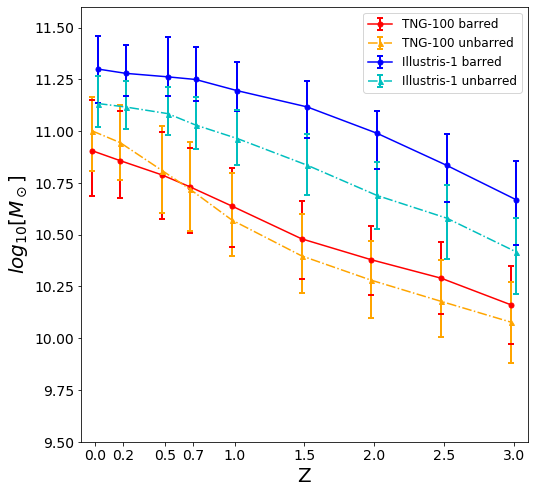

In [68]:
DMhaloMassInRad()

In [54]:
def DMhaloMass():
    rs = np.array([0, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0])
    il1_snap = [135, 120, 108, 95, 85, 75, 68]
    tng_snap = [99, 84, 67, 59, 50, 40, 33]
    
    il1_Y, il1_Err = Ydata('il1', il1_barID, il1_subDM, il1_snap, rs)
    il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_subDM, il1_snap, rs)
    tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_subDM, tng_snap, rs)
    tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_subDM, tng_snap, rs)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$z$', fontsize=20)
    ax.set_ylabel(r'$log_{10}(M_{DM}[M_\odot])$', fontsize=20)
    # ax.set_yscale("log")
#     ax.set_xlim(-0.1, 3.1)
#     ax.set_ylim(9.5, 11.6)
    ax.set_xticks(rs)
    # ax.set_title("Galaxies(subhalo) dark matter mass")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.errorbar(rs+0.02, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, ls='-', label='Illustris-1 barred')
    ax.errorbar(rs+0.02, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ms=5, ls='-.', label='Illustris-1 unbarred')
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)
    ax.set_xlim(-0.1, 2.1)
    plt.savefig('f:/Linux/local_result/subDM_mass_20.pdf')

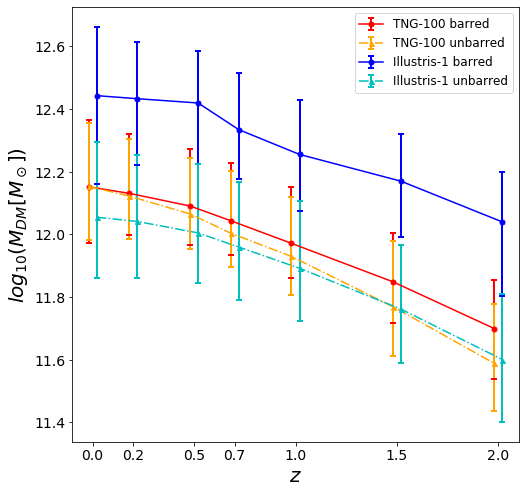

In [55]:
DMhaloMass()

In [17]:
il1_subDM

{135: array([ 4.4561005,  3.4879591,  2.8875759, ..., -1.7261147, -1.756078 ,
        -1.698086 ], dtype=float32),
 120: array([ 4.2930775,  3.4251728,  2.6231654, ..., -1.7118742, -1.698086 ,
        -1.7261147], dtype=float32),
 108: array([ 4.2149105,  2.3490732,  2.332453 , ..., -1.756078 , -1.7718723,
        -1.8608133], dtype=float32),
 95: array([ 4.0879054,  2.834884 ,  2.3319466, ..., -1.7882626, -1.7882626,
        -1.740838 ], dtype=float32),
 85: array([ 3.8742483,  3.1356063,  2.5427883, ..., -1.902206 , -1.740838 ,
        -1.756078 ], dtype=float32),
 75: array([ 3.3311832,  2.9952502,  2.298074 , ..., -1.740838 , -1.7261147,
        -1.7118742], dtype=float32),
 68: array([ 3.440319 ,  1.8425132,  1.0815781, ..., -1.740838 , -1.8415082,
        -1.902206 ], dtype=float32),
 64: array([ 3.357471 ,  1.5172788, -1.253846 , ..., -1.756078 , -1.7261147,
        -1.805296 ], dtype=float32),
 60: array([ 2.8422098,  2.5342293,  1.8229785, ..., -1.740838 , -1.7718723,
        

In [27]:
def fof_Ydata(simu, ids, rawdata, SnapList, Redshift, GID):
    dataWithZ = {}
    for x in Redshift:
        dataWithZ[x] = []
    #all each halo's information into 'dataWithZ'
    for subID in ids:
        data = []
        prog = LoadMergHist(simu, subID)[0]
        plot = 1
        for snap in SnapList:
            try:
                haloID = prog[snap]
                gid = GID[snap][haloID]
                data.append(rawdata[snap][gid])
            except:
                plot = 0       

        if plot:
            for i in range(len(data)):
                dataWithZ[Redshift[i]].append(data[i])

    #calculate Error bar
    plotdata = [[], [], []]
    for i in range(len(data)):
        d0, d1, d2 = ErrorBarMedian(dataWithZ[Redshift[i]])
        plotdata[0].append(d0)
        plotdata[1].append(d1)
        plotdata[2].append(d2)
    plotdata = np.array(plotdata)
    Err = np.vstack((plotdata[1,:] - plotdata[0,:], plotdata[2,:] - plotdata[1,:]))
    return plotdata[1, :], Err

In [70]:
def FOF_R500():
    il1_Y, il1_Err = fof_Ydata('il1', il1_barID, il1_r500, il1_snap, rs, il1_Groups)
    il1_Y_2, il1_Err_2 = fof_Ydata('il1', il1_unbar, il1_r500, il1_snap, rs, il1_Groups)
    tng_Y, tng_Err = fof_Ydata('TNG', tng_barID, tng_r500, tng_snap, rs, tng_Groups)
    tng_Y_2, tng_Err_2 = fof_Ydata('TNG', tng_unbar, tng_r500, tng_snap, rs, tng_Groups)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Z', fontsize=20)
    ax.set_ylabel(r'$log_{10}[M_\odot]}$', fontsize=20)
    # ax.set_yscale("log")
    ax.set_xlim(-0.1, 3.1)
    ax.set_ylim(10.8, 13.6)
    ax.set_xticks(rs)
    # ax.set_title("Galaxy host FOF halos(Group) dark matter mass")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.errorbar(rs+0.02, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, ls='-', label='Illustris-1 barred')
    ax.errorbar(rs+0.02, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ms=5, ls='-.', label='Illustris-1 unbarred')
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)
    plt.savefig('f:/Linux/local_result/R500_mass.pdf')

In [56]:
def FOF_R200():
    rs = np.array([0, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0])
    il1_snap = [135, 120, 108, 95, 85, 75, 68]
    tng_snap = [99, 84, 67, 59, 50, 40, 33]
    
    il1_Y, il1_Err = fof_Ydata('il1', il1_barID, il1_r200, il1_snap, rs, il1_Groups)
    il1_Y_2, il1_Err_2 = fof_Ydata('il1', il1_unbar, il1_r200, il1_snap, rs, il1_Groups)
    tng_Y, tng_Err = fof_Ydata('TNG', tng_barID, tng_r200, tng_snap, rs, tng_Groups)
    tng_Y_2, tng_Err_2 = fof_Ydata('TNG', tng_unbar, tng_r200, tng_snap, rs, tng_Groups)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$z$', fontsize=20)
    ax.set_ylabel(r'$log_{10}(M[M_\odot])}$', fontsize=20)
    # ax.set_yscale("log")
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(11, 13.6)
    ax.set_xticks(rs)
    # ax.set_title("Galaxy host FOF halos(Group) dark matter mass")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.errorbar(rs+0.02, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, ls='-', label='Illustris-1 barred')
    ax.errorbar(rs+0.02, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ms=5, ls='-.', label='Illustris-1 unbarred')
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)
    ax.set_xlim(-0.1, 2.1)
    plt.savefig('f:/Linux/local_result/R200_mass_20.pdf')

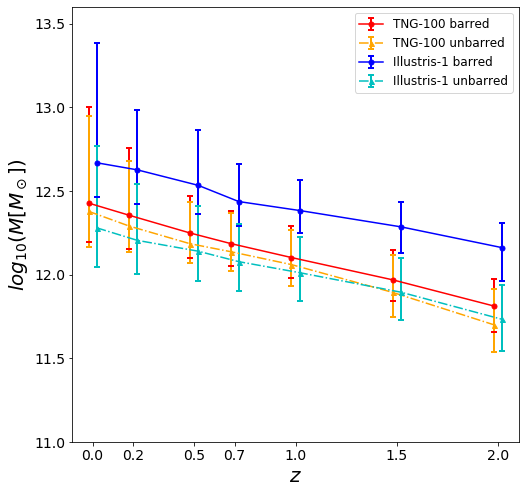

In [57]:
FOF_R200()

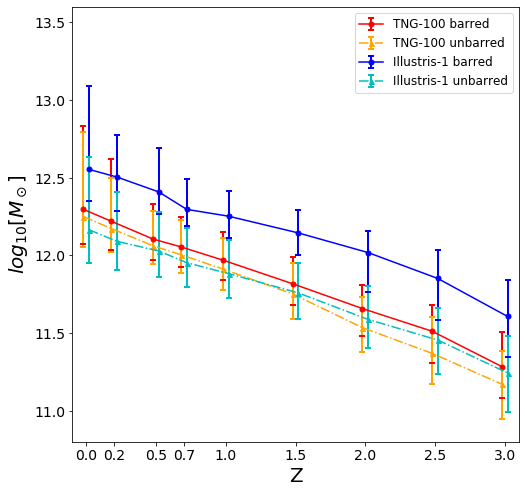

In [73]:
FOF_R500()

In [74]:
def Edot(BHMdot):
    Edot_kine = (2.83 / 4.89) * 1e45 * BHMdot
    return Edot_kine

energy = {}
for i in tng_BHdot.keys():
    energy[i] = np.log10(Edot(tng_BHdot[i]))

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [75]:
energy

{99: array([41.36237183, 41.12445062, 41.78531243, ...,        -inf,
               -inf,        -inf]),
 84: array([39.45866208, 41.16336269, 41.65350548, ...,        -inf,
               -inf,        -inf]),
 67: array([41.72429022, 41.35869581, 41.10611558, ...,        -inf,
               -inf,        -inf]),
 59: array([42.86508478, 40.3756977 , 41.62130901, ...,        -inf,
               -inf,        -inf]),
 50: array([41.68115106, 41.16867827, 41.2326243 , ...,        -inf,
               -inf,        -inf]),
 40: array([41.61822492, 42.97256831, 40.54376076, ...,        -inf,
               -inf,        -inf]),
 33: array([42.58710383, 43.0921292 , 40.2305358 , ...,        -inf,
               -inf,        -inf]),
 29: array([42.96781973, 43.90309214, 41.18892965, ...,        -inf,
               -inf,        -inf]),
 25: array([42.41087716, 43.40237662, 43.23638791, ...,        -inf,
               -inf,        -inf])}

In [76]:
def AGN_Energy():
    tng_Y, tng_Err = Ydata('TNG', tng_barID, energy, tng_snap, rs)
    tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, energy, tng_snap, rs)


    #plot info
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Z', fontsize=20)
    ax.set_ylabel(r'$log_{10}(E_{kinetic AGN}$ erg/s)', fontsize=20)
    ax.set_xlim(-0.1, 3.1)
    ax.set_xticks(rs)
    # ax.set_yscale("log")
    # ax.set_ylim(0.1, 0.00000001)
    # ax.set_title(r"TNG galaxies BlackHole accretion rates")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)
    ax.legend()
    # plt.savefig('f:/Linux/local_result/BH/en.eps')

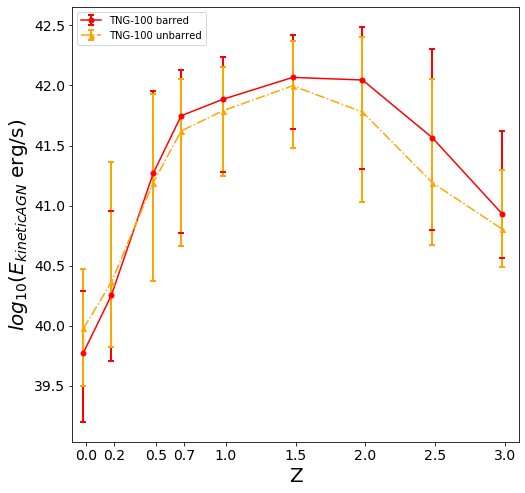

In [77]:
AGN_Energy()

In [17]:
rs = np.array([0, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0])
il1_snap = [135, 120, 108, 95, 85, 75, 68, 64, 60]
tng_snap = [99, 84, 67, 59, 50, 40, 33, 29, 25]

In [58]:
def Global_GasFraction_renew():
    #Global_il1-TNG_Gasfration
    il1_Y, il1_Err = Ydata('il1', il1_barID, il1_GF, il1_snap, rs)
    il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_GF, il1_snap, rs)
            
    tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_GF, tng_snap, rs)
    tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_GF, tng_snap, rs)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'$z$', fontsize=20)
    ax.set_ylabel(r'Gas Fraction', fontsize=20)
    # ax.set_yscale("log")
    ax.set_xlim(-0.1, 3.1)
    ax.set_ylim(-0.02, 0.85)
    ax.set_xticks(rs)
    # ax.set_title(r"il1&TNG galaxies gas fraction")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.errorbar(rs+0.02, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, ls='-', label='Illustris-1 barred')
    ax.errorbar(rs+0.02, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ms=5, ls='-.', label='Illustris-1 unbarred')
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)
#     ax.legend(loc = 2)
    plt.savefig('f:/Linux/local_result/SFR-GF/Global_GasFraction_renew.pdf')

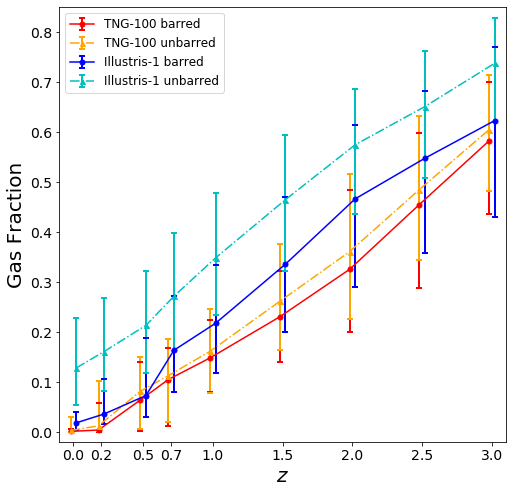

In [59]:
Global_GasFraction_renew()

In [60]:
def Global_SFR_renew():
    #Global_il1-TNG_GAS
    il1_Y, il1_Err = Ydata('il1', il1_barID, il1_SFR, il1_snap, rs)
    il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_SFR, il1_snap, rs)
            
    tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_SFR, tng_snap, rs)
    tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_SFR, tng_snap, rs)

    #plot info
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$z$', fontsize=20)
    ax.set_ylabel(r'SFR [$M_\odot/yr$]', fontsize=20)
    # ax.set_yscale("log")
    ax.set_xlim(-0.1, 3.1)
    ax.set_xticks(rs)
    # ax.set_ylim(-0.02, 0.85)
    # ax.set_title(r"il1&TNG galaxies star formation rate")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.errorbar(rs+0.02, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, ls='-', label='Illustris-1 barred')
    ax.errorbar(rs+0.02, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ms=5, ls='-.', label='Illustris-1 unbarred')
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)
    plt.savefig('f:/Linux/local_result/SFR-GF/Global_SFR_renew.pdf')

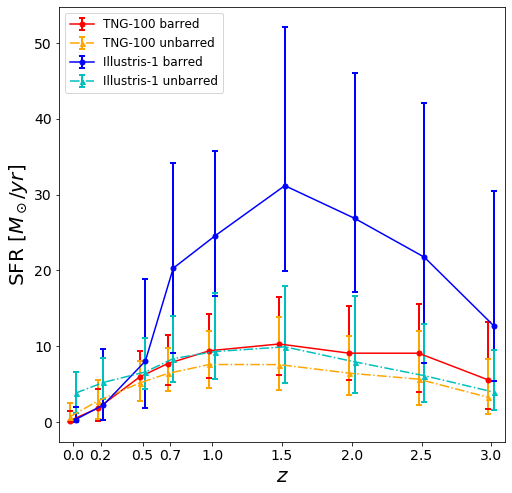

In [61]:
Global_SFR_renew()

In [17]:
def Global_sSFR():
    #Global_il1-TNG_GAS
    il1_Y, il1_Err = Ydata('il1', il1_barID, il1_sSFR, il1_snap, rs)
    il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_sSFR, il1_snap, rs)
            
    tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_sSFR, tng_snap, rs)
    tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_sSFR, tng_snap, rs)

    #plot info
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$z$', fontsize=20)
    ax.set_ylabel(r'sSFR $[yr^{-1}]$', fontsize=20)
    ax.set_yscale("log")
    ax.set_xlim(-0.1, 3.1)
    ax.set_xticks(rs)
    # ax.set_ylim(-0.02, 0.85)
    # ax.set_title(r"il1&TNG galaxies star formation rate")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.errorbar(rs+0.02, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, ls='-', label='Illustris-1 barred')
    ax.errorbar(rs+0.02, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ms=5, ls='-.', label='Illustris-1 unbarred')
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)
#     plt.savefig('f:/Linux/local_result/SFR-GF/Global_sSFR.pdf')

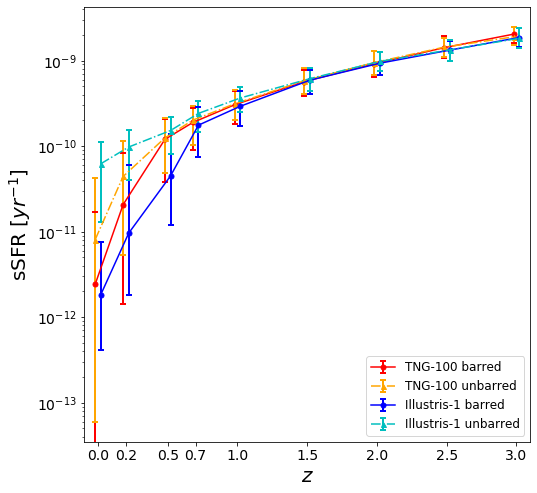

In [18]:
Global_sSFR()

In [32]:
def Global_MgasDivSFR():
    #Global_il1-TNG_GAS
    il1_Y, il1_Err = Ydata('il1', il1_barID, il1_MgasDivSFR, il1_snap, rs)
    il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_MgasDivSFR, il1_snap, rs)
            
    tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_MgasDivSFR, tng_snap, rs)
    tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_MgasDivSFR, tng_snap, rs)

    #plot info
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$z$', fontsize=20)
    ax.set_ylabel(r'$\frac{M_{gas}}{SFR}[yr]$', fontsize=20)
    ax.set_yscale("log")
    ax.set_xlim(-0.1, 3.1)
    ax.set_xticks(rs)
    # ax.set_ylim(-0.02, 0.85)
    # ax.set_title(r"il1&TNG galaxies star formation rate")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.errorbar(rs+0.02, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, ls='-', label='Illustris-1 barred')
    ax.errorbar(rs+0.02, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ms=5, ls='-.', label='Illustris-1 unbarred')
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)
    plt.savefig('f:/Linux/result_v2/MgasDivSFR.pdf')

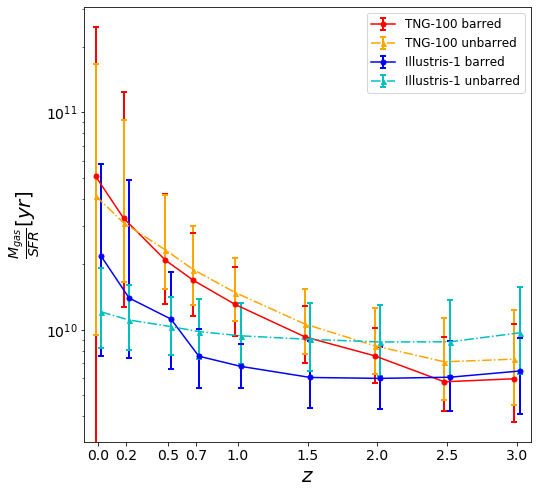

In [33]:
Global_MgasDivSFR()

In [ ]:
#Part-B : Black Hole 

In [50]:
def Global_BHdot():
    il1_Y, il1_Err = Ydata('il1', il1_barID, il1_BHdot, il1_snap, rs)
    il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_BHdot, il1_snap, rs)
            
    tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_BHdot, tng_snap, rs)
    tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_BHdot, tng_snap, rs)

    #plot info
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$z$', fontsize=20)
    ax.set_ylabel(r'$\dot{M}_{BH}[10^{10} M_\odot / Gyr]$', fontsize=20)
    ax.set_yscale("log")
    ax.set_xlim(-0.1, 3.1)
    ax.set_xticks(rs)
    # ax.set_ylim(0.1, 0.00000001)
    # ax.set_title(r"TNG galaxies BlackHole accretion rates")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.errorbar(rs+0.02, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, ls='-', label='Illustris-1 barred')
    ax.errorbar(rs+0.02, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ms=5, ls='-.', label='Illustris-1 unbarred')
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)

    plt.savefig('f:/Linux/local_result/BH/Global_BHdot.pdf')

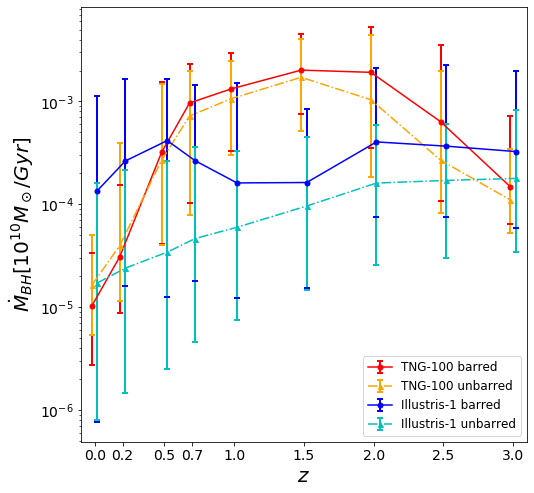

In [51]:
Global_BHdot()

In [52]:
def Global_BHmass():
    #Global_il1-TNG_BHmass
    il1_Y, il1_Err = Ydata('il1', il1_barID, il1_BHMass, il1_snap, rs)
    il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_BHMass, il1_snap, rs)
            
    tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_BHMass, tng_snap, rs)
    tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_BHMass, tng_snap, rs)


    #plot info
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$z$', fontsize=20)
    ax.set_ylabel(r'$log_{10}(M_*/M_\odot)$', fontsize=20)
#     ax.set_yscale("log")
    ax.set_xlim(-0.1, 3.1)
    ax.set_xticks(rs)
    # ax.set_ylim(0.1, 0.00000001)
    # ax.set_title(r"TNG & Illustris-1 galaxies BlackHole Mass")

    #lines
    ax.errorbar(rs-0.02, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o',ms=5, ls='-', label='TNG-100 barred')
    ax.errorbar(rs-0.02, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='orange', fmt='^',ms=5, ls='-.', label='TNG-100 unbarred')
    ax.errorbar(rs+0.02, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, ls='-', label='Illustris-1 barred')
    ax.errorbar(rs+0.02, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', ms=5, ls='-.', label='Illustris-1 unbarred')
    
    ax.tick_params(labelsize=14)
    ax.legend(loc = 0, fontsize=12)
    plt.savefig('f:/Linux/local_result/BH/Global_BHmass.pdf')

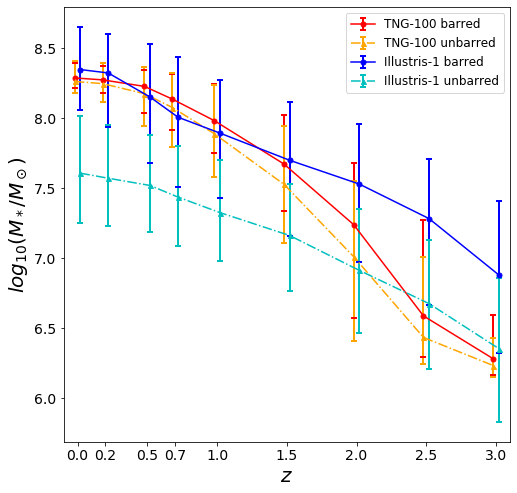

In [53]:
Global_BHmass()

In [41]:
# il1_BHdot, il1_SFR
il1_Y_Mdot, il1_Err = Ydata('il1', il1_barID, il1_BHdot, il1_snap, rs)
il1_Y_Mdot_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_BHdot, il1_snap, rs)

il1_X_SFR, il1_Err_SFR = Ydata('il1', il1_barID, il1_SFR, il1_snap, rs)
il1_X_SFR_2, il1_Err_SFR_2 = Ydata('il1', il1_unbar, il1_SFR, il1_snap, rs)


tng_Y_Mdot, tng_Err = Ydata('TNG', tng_barID, tng_BHdot, tng_snap, rs)
tng_Y_Mdot_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_BHdot, tng_snap, rs)

tng_X_SFR, tng_Err_SFR = Ydata('TNG', tng_barID, tng_SFR, tng_snap, rs)
tng_X_SFR_2, tng_Err_SFR_2 = Ydata('TNG', tng_unbar, tng_SFR, tng_snap, rs)

Text(0.5, 0, 'SFR [$M_\\odot/yr$]')

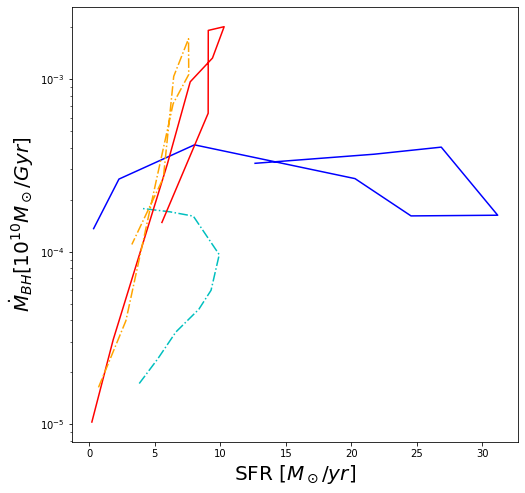

In [66]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.plot(il1_X_SFR, il1_Y_Mdot, c='b')
ax.plot(il1_X_SFR_2, il1_Y_Mdot_2, c='c', ls='-.')
# ax.quiver(il1_Y_Mdot[:-1], il1_X_SFR[:-1], il1_Y_Mdot[1:]-il1_Y_Mdot[:-1], il1_X_SFR[1:]-il1_X_SFR[:-1], color='r')
# ax.quiver(il1_Y_Mdot_2[:-1], il1_X_SFR_2[:-1], np.ones(len(il1_Y_Mdot)), np.ones(len(il1_Y_Mdot)), color='orange')

ax.plot(tng_X_SFR, tng_Y_Mdot, c='r')
ax.plot(tng_X_SFR_2, tng_Y_Mdot_2, c='orange', ls='-.')

ax.set_yscale('log')

ax.set_ylabel(r'$\dot{M}_{BH}[10^{10} M_\odot / Gyr]$', fontsize=20)
ax.set_xlabel(r'SFR [$M_\odot/yr$]', fontsize=20)


In [ ]:
# M_dot / M_BH vs. sSFR
il1_Y_Mdot, il1_Err = Ydata('il1', il1_barID, il1_BHdot, il1_snap, rs)
il1_Y_Mdot_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_BHdot, il1_snap, rs)

il1_X_SFR, il1_Err_SFR = Ydata('il1', il1_barID, il1_SFR, il1_snap, rs)
il1_X_SFR_2, il1_Err_SFR_2 = Ydata('il1', il1_unbar, il1_SFR, il1_snap, rs)


tng_Y_Mdot, tng_Err = Ydata('TNG', tng_barID, tng_BHdot, tng_snap, rs)
tng_Y_Mdot_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_BHdot, tng_snap, rs)

tng_X_SFR, tng_Err_SFR = Ydata('TNG', tng_barID, tng_SFR, tng_snap, rs)
tng_X_SFR_2, tng_Err_SFR_2 = Ydata('TNG', tng_unbar, tng_SFR, tng_snap, rs)